In [1]:
#default_exp data_bunch

In [2]:
#hide
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import show_doc

#the only torch import we will have in the project
from torch import tensor
import random

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *
from PIL import Image

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import pdb
import fastai.vision.image as im


# Custom DataBunch Object

In [3]:
path = Path()/'horse2zebra'

In [4]:
#exports
class DoubleImage(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.data = [(-1+2*img1.data),(-1+2*img2.data)]
    
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [-1+2*self.img1.data,-1+2*self.img2.data]
        return self
    
    def __repr__(self)->str: return f'{self.__class__.__name__}'
    
    def to_one(self): 
        tensor = 0.5+torch.cat(self.data,2)/2
        return im.Image(tensor)

In [5]:
#exports
class DoubleImageList(ImageList):
    def __init__(self, items, itemsB=None, **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return DoubleImage(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): return t
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
        "Set `tfms` to be applied to the xs of the train and validation set."
        if not tfms: tfms=(None,None)
        assert is_listy(tfms) and len(tfms) == 2, "Please pass a list of two lists of transforms (train and valid)."
        self.train.transform(tfms[0], **kwargs)
        self.valid.transform(tfms[1], **kwargs)
        if self.test: self.test.transform(tfms[1], **kwargs)
        return self
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i] = DoubleImage((xs[i][0]/2+0.5),(xs[i][1]/2+0.5))
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    #UNTESTED
    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [6]:
data = DoubleImageList.from_folders(path, 'trainA', 'trainB').split_by_rand_pct(0.2).label_from_folder()

In [7]:
data = ImageDataBunch.create_from_ll(data, bs=1, size=224)

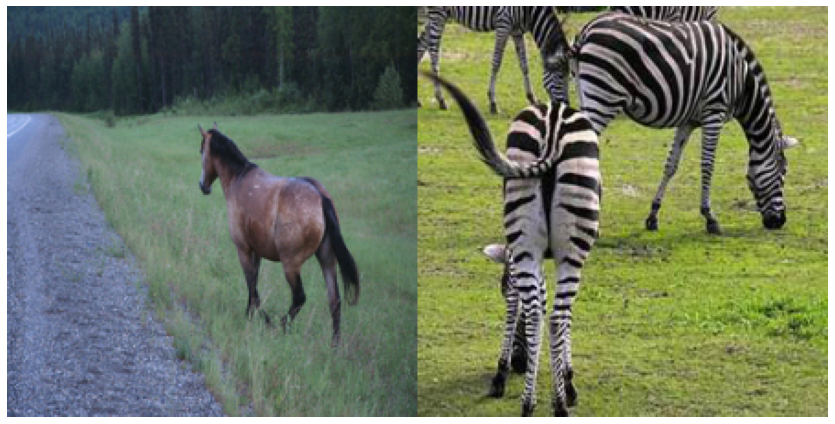

In [8]:
data.show_batch()